In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import gsw
from dask.diagnostics import ProgressBar
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [13]:
ds = xr.open_mfdataset('../data/processed/regridded/CESM1.2_CAM5.*.mean.1x1.nc')
grid = xr.open_dataset('../data/processed/regridded/grid_1x1_depth.nc')

In [16]:
ds.experiment

<xarray.DataArray 'experiment' (experiment: 5)> Size: 380B
array(['deepmip_sens_1xCO2', 'deepmip_sens_9xCO2', 'deepmip_stand_3xCO2',
       'deepmip_stand_6xCO2', 'piControl'], dtype='<U19')
Coordinates:
  * experiment  (experiment) <U19 380B 'deepmip_sens_1xCO2' ... 'piControl'

In [18]:
ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])

In [20]:
time = None
if time is None:
    ds = ds.mean('time')
else:
    ds = ds.sel(time=time)

In [22]:
# extract bottom values
# can find last entry by finding the depth at which the cumulative sum stops changing
bathy = np.abs(ds.sel(experiment='deepmip_sens_1xCO2')['thetao']).cumsum('z').argmax('z').compute()

# Sections

In [18]:
experiment = 'deepmip_sens_9xCO2'
dsnow = ds.sel(experiment=experiment)

### lat-lon

In [21]:
depths = [0, 1000, 2000, 4000]

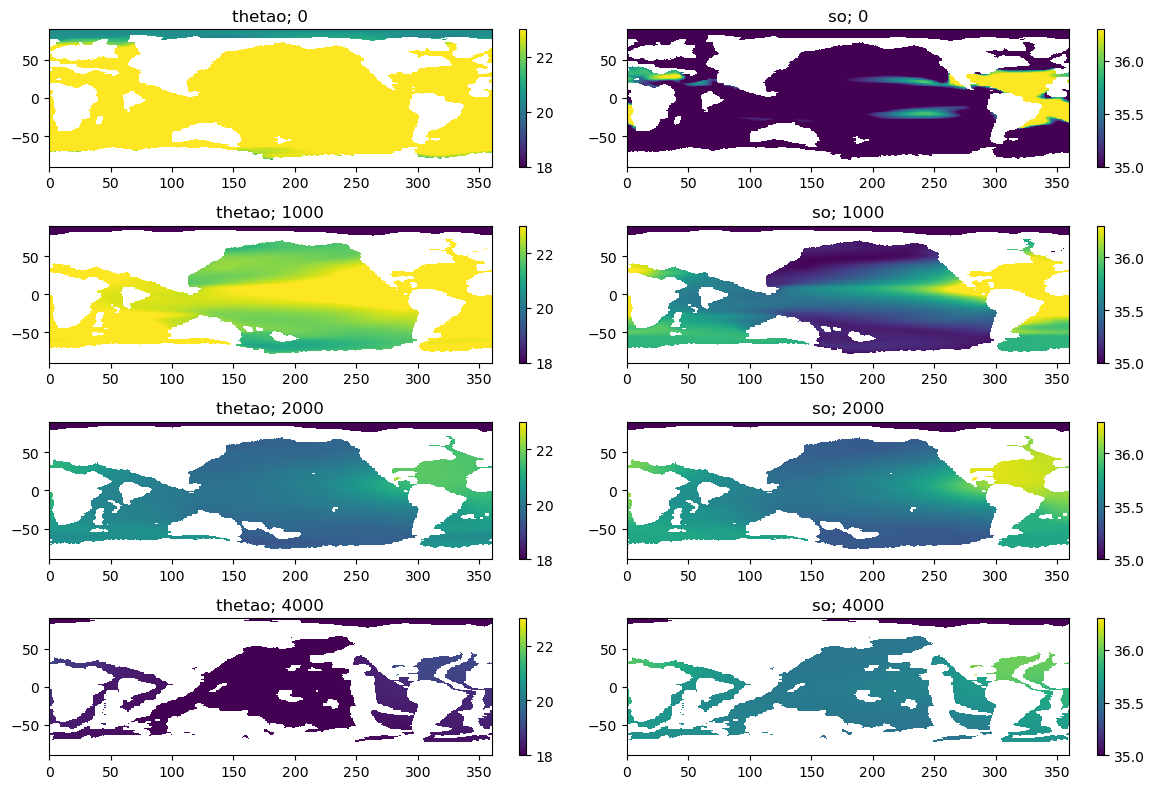

In [23]:
fig,ax = plt.subplots(figsize=(12,8),ncols=2,nrows=len(depths))
for i,depth in enumerate(depths):
    dssec = dsnow.sel(z=depth,method='nearest').squeeze()
    for j,variable in enumerate(['thetao','so']):
        da = dssec[variable]
        axnow = ax[i,j]
        im = axnow.pcolormesh(da.x,da.y,da)
        axnow.set_title(variable+'; '+str(depth))
        if variable=='thetao':
            im.set_clim([18,23])
        elif variable=='so':
            im.set_clim([35,36.3])
        plt.colorbar(im,ax=axnow)
fig.tight_layout()

### bottom depth

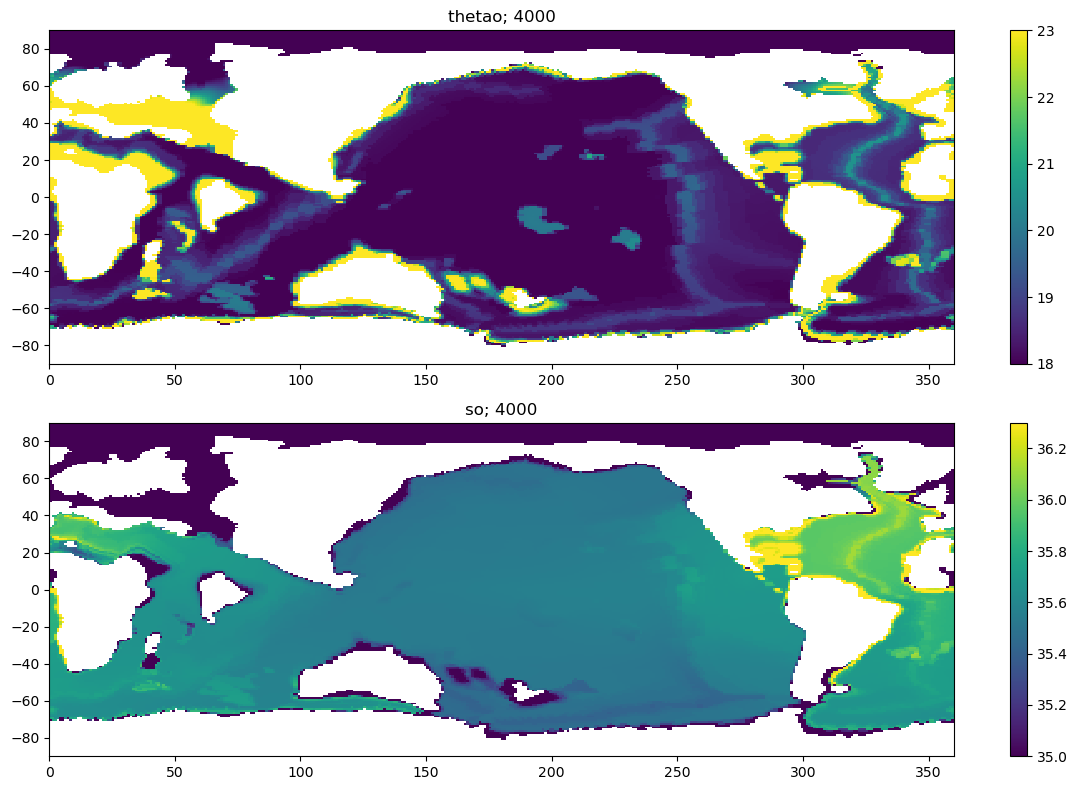

In [25]:
fig,ax = plt.subplots(figsize=(12,8),nrows=2)
dssec = dsnow.isel(z=bathy).squeeze()
for j,variable in enumerate(['thetao','so']):
    da = dssec[variable]
    axnow = ax[j]
    im = axnow.pcolormesh(da.x,da.y,da)
    axnow.set_title(variable+'; '+str(depth))
    if variable=='thetao':
        im.set_clim([18,23])
    elif variable=='so':
        im.set_clim([35,36.3])
    plt.colorbar(im,ax=axnow)
fig.tight_layout()

### lat-z

In [718]:
lon = 220

In [719]:
dssec = dsnow.sel(x=lon,method='nearest').squeeze()
with ProgressBar():
    dssec = dssec.compute()

[########################################] | 100% Completed | 14.83 ss


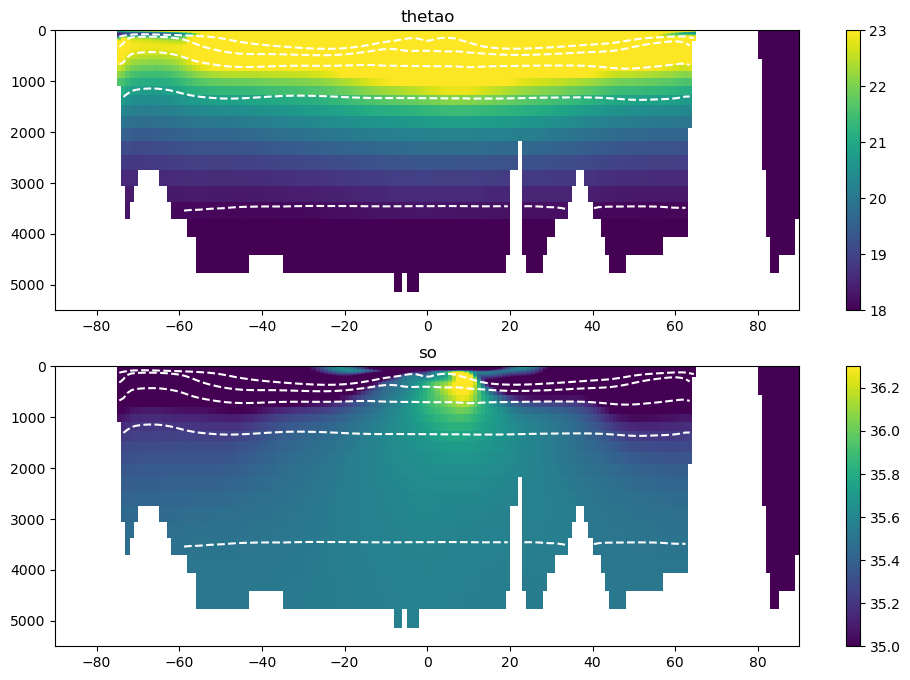

In [720]:
fig,ax = plt.subplots(figsize=(12,8),nrows=2)
for i,variable in enumerate(['thetao','so']):
    da = dssec[variable]
    axnow = ax[i]
    im = axnow.pcolormesh(da.y,da.z,da)
    if variable=='thetao':
        im.set_clim([18,23])
    elif variable=='so':
        im.set_clim([35,36.3])
    axnow.invert_yaxis()
    axnow.set_title(variable)
    axnow.contour(da.y,da.z,dssec['sigma2'],[30,31,32,33,34],colors='w',linestyles='--')
    plt.colorbar(im,ax=axnow)

## lon-z

In [722]:
lat = 30

In [723]:
dssec = dsnow.sel(y=lat,method='nearest').squeeze()
with ProgressBar():
    dssec = dssec.compute()

[########################################] | 100% Completed | 12.37 ss


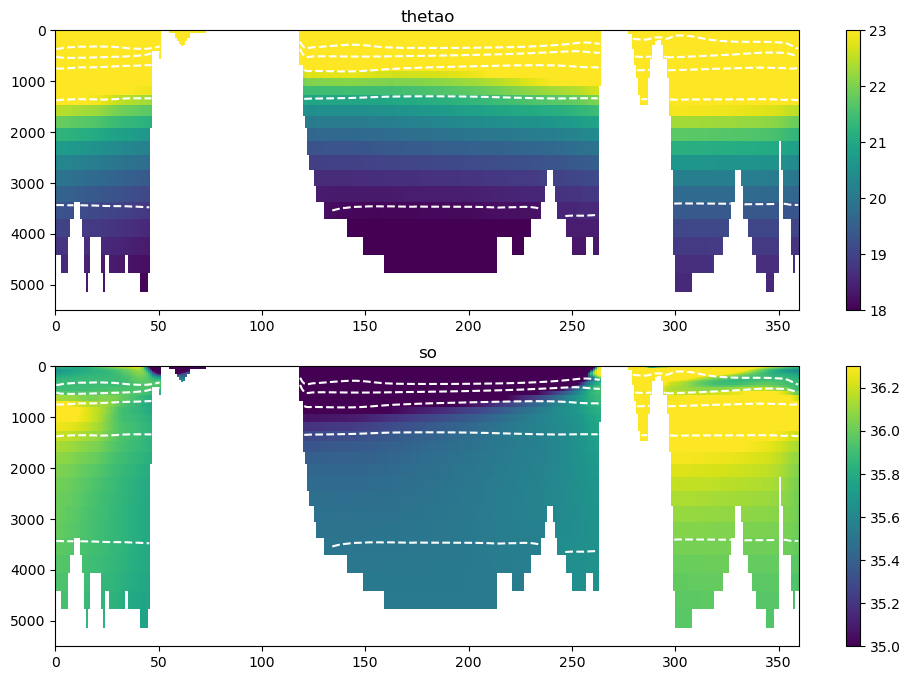

In [724]:
fig,ax = plt.subplots(figsize=(12,8),nrows=2)
for i,variable in enumerate(['thetao','so']):
    da = dssec[variable]
    axnow = ax[i]
    im = axnow.pcolormesh(da.x,da.z,da)
    if variable=='thetao':
        im.set_clim([18,23])
    elif variable=='so':
        im.set_clim([35,36.3])
    axnow.invert_yaxis()
    axnow.set_title(variable)
    axnow.contour(da.x,da.z,dssec['sigma2'],[30,31,32,33,34],colors='w',linestyles='--')
    plt.colorbar(im,ax=axnow)

## All experiments

In [24]:
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

In [26]:
lon = 220
dssec = ds.sel(x=lon,method='nearest')
with ProgressBar():
    dssec = dssec.compute()

[########################################] | 100% Completed | 17.20 ss


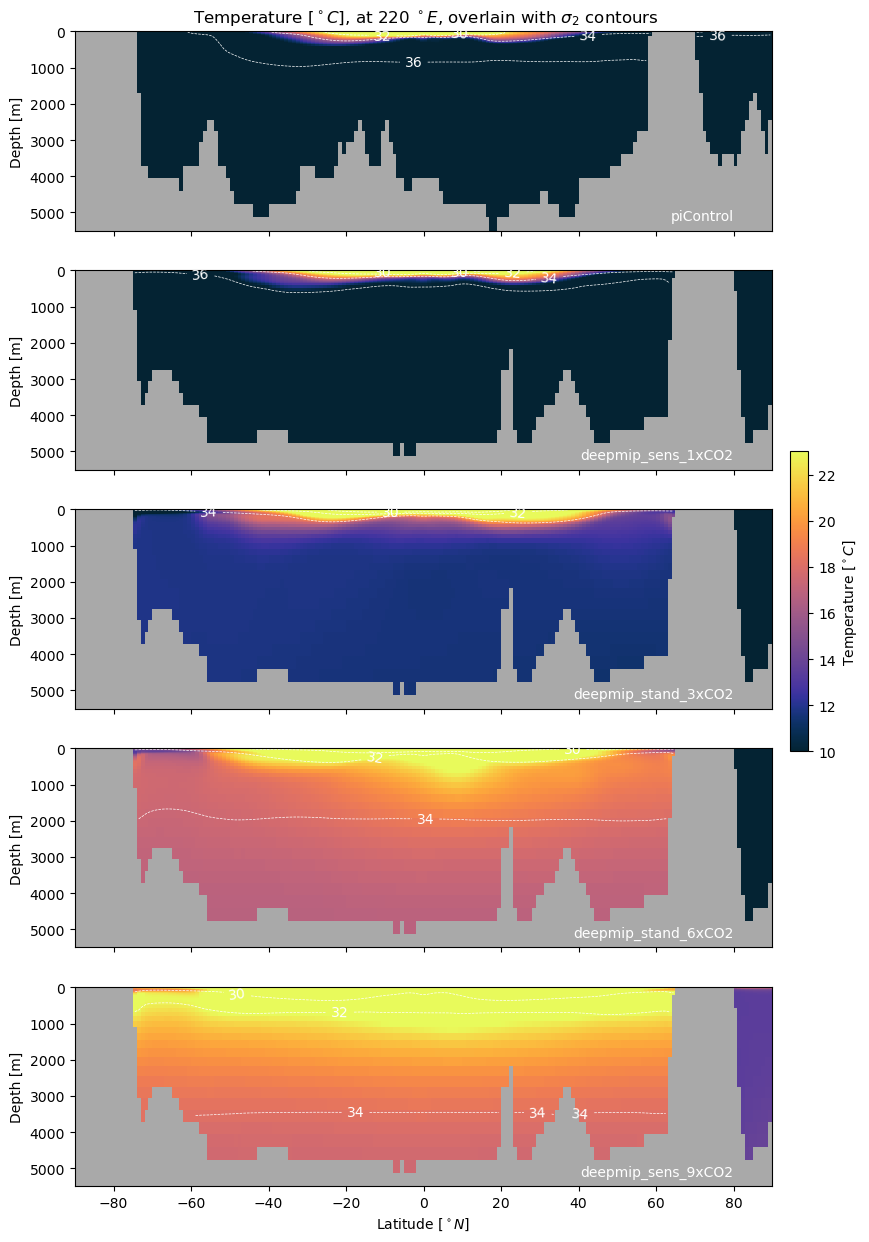

In [1202]:
variable = 'thetao'
if variable=='thetao':
    clims = [10,23]
    longname = 'Temperature [$^\circ C$]'
    cmap = cmocean.cm.thermal
elif variable=='so':
    longname = 'Salinity [psu]'
    clims = [33.5,36.3]
    cmap = cmocean.cm.haline

cmap.set_bad(color='darkgrey')
ne = len(experiments)
fig,axarr = plt.subplots(figsize=(9,3*ne),nrows=ne)
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = dssec.sel(experiment=experiment)[variable]
    sigma2 = dssec.sel(experiment=experiment)['sigma2']
    damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.pcolormesh(da['y'],da['z'],da,cmap=cmap)
    cs = axnow.contour(da['y'],da['z'],sigma2,[30,32,34,36],colors='w',linestyles='--',linewidths=0.5)
    axnow.clabel(cs)
    axnow.text(80,5200,experiment,color='w',ha='right',fontweight=12)
    axnow.invert_yaxis()
    axnow.set_ylabel(r'Depth [m]')
    if i==ne-1:
        axnow.set_xlabel(r'Latitude [$^\circ N$]')
    else:
        axnow.set_xticklabels([])
    im.set_clim(clims)
    if i==0:
        axnow.set_title(r' '+longname+', at '+str(lon)+' $^\circ E$, overlain with $\sigma_2$ contours')
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

# Stratification

In [1275]:
zs = [100,2000]
strat = (ds['sigma2'].sel(z=zs[1],method='nearest')-ds['sigma2'].sel(z=zs[0],method='nearest')).squeeze()
with ProgressBar():
    strat = strat.compute()

[########################################] | 100% Completed | 11.73 s


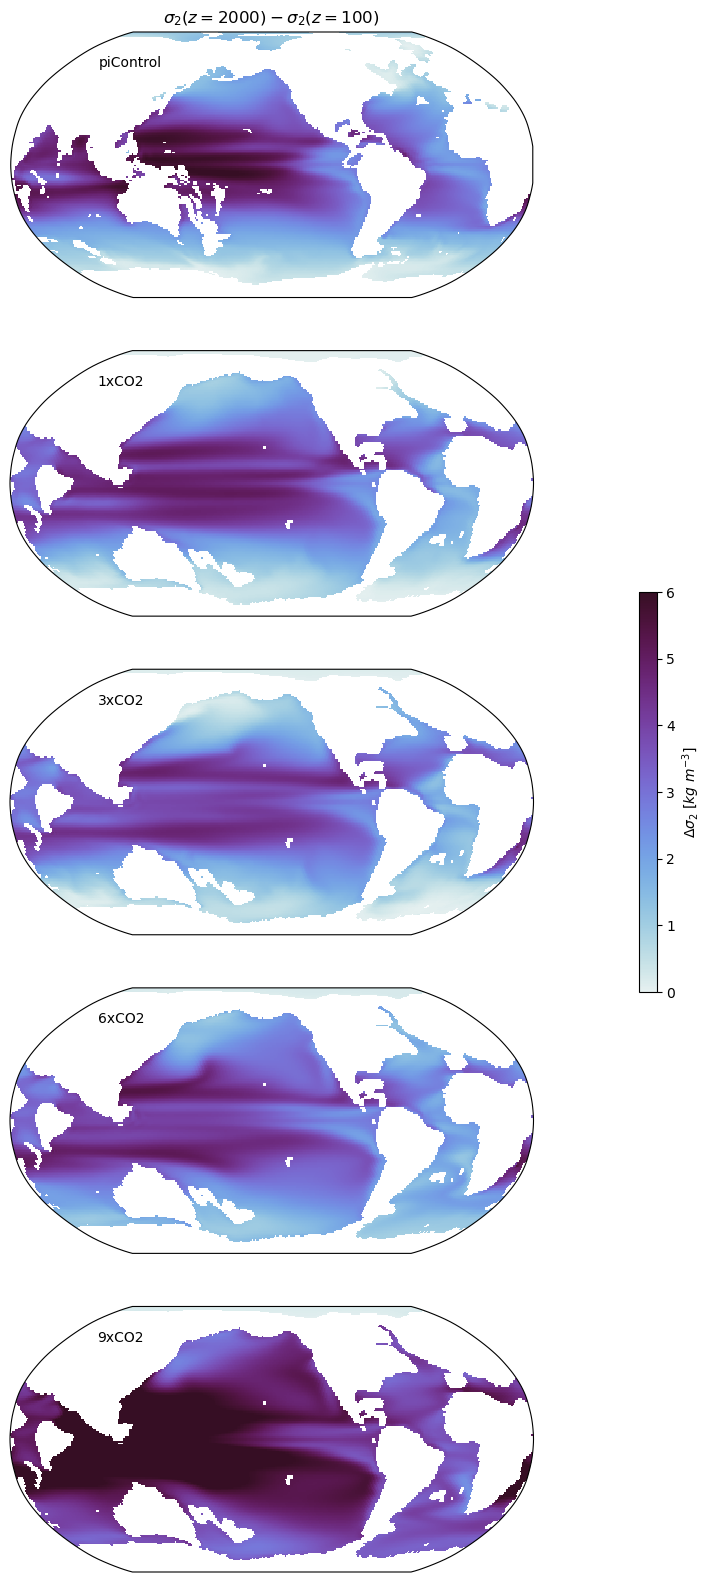

In [1290]:
cmap = cmocean.cm.dense
cmap.set_bad(color='darkgrey',alpha=0)
ne = len(experiments)
fig,axarr = plt.subplots(figsize=(9,4*ne),nrows=ne,subplot_kw={'projection':ccrs.Robinson(central_longitude=220)})
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = strat.sel(experiment=experiment)
    im = axnow.pcolormesh(da['x'],da['y'],da,transform=ccrs.PlateCarree(),cmap=cmap)
    axnow.text(70,60,experiment.split('_')[-1],color='k',ha='left',fontweight=12,transform=ccrs.PlateCarree())
    im.set_clim([0,6])
    if i==0:
        axnow.set_title(r'$\sigma_2(z='+str(zs[1])+')-\sigma_2(z='+str(zs[0])+')$')
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label('$\Delta \sigma_2$ [$kg\ m^{-3}$]')

# T-S diagrams

In [983]:
tlims = [-2,48]
slims = [10,40]
tv = np.arange(tlims[0],tlims[1],0.1)
sv = np.arange(slims[0],slims[1],0.02)
sarray,tarray = np.meshgrid(sv,tv)
sig2array = gsw.sigma2(sarray,tarray)

In [985]:
experiment = 'deepmip_sens_9xCO2'
dsnow = ds.sel(experiment=experiment)

### surface and bottom

In [988]:
yarray = dsnow['y']*xr.ones_like(dsnow['x']) # broadcast latitude

In [990]:
with ProgressBar():
    dss = dsnow.isel(z=0).load()
    dsb = dsnow.isel(z=bathy).load()

[########################################] | 100% Completed | 18.16 ss
[########################################] | 100% Completed | 21.26 ss


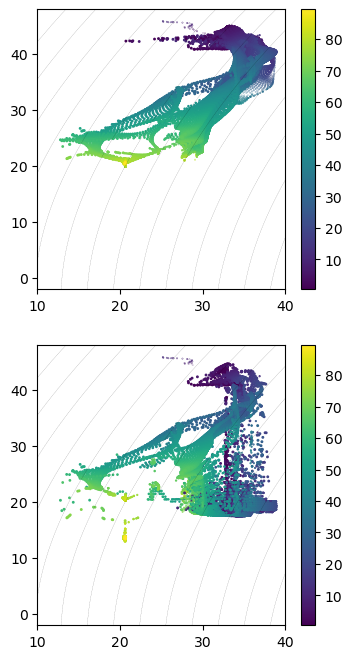

In [992]:
fig,ax = plt.subplots(figsize=(4,8),nrows=2)
im = ax[0].scatter(dss['so'],dss['thetao'],s=grid['area'].values*1e-10,c=np.abs(yarray))
ax[0].contour(sv,tv,sig2array,levels=15,colors='k',linestyles='--',linewidths=0.1)
ax[0].set_ylim(tlims)
ax[0].set_xlim(slims)
plt.colorbar(im,ax=ax[0])
im = ax[1].scatter(dss['so'],dsb['thetao'],s=grid['area'].values*1e-10,c=np.abs(yarray))
ax[1].contour(sv,tv,sig2array,levels=15,colors='k',linestyles='--',linewidths=0.1)
ax[1].set_ylim(tlims)
ax[1].set_xlim(slims)
plt.colorbar(im,ax=ax[1])

## T-S diagrams for all experiments

In [1135]:
yarray = ds['y']*xr.ones_like(ds['x']) # broadcast latitude
with ProgressBar():
    dss = ds.isel(z=0).load()

[########################################] | 100% Completed | 16.88 ss


In [1137]:
import matplotlib as mpl

(10.0, 40.0)

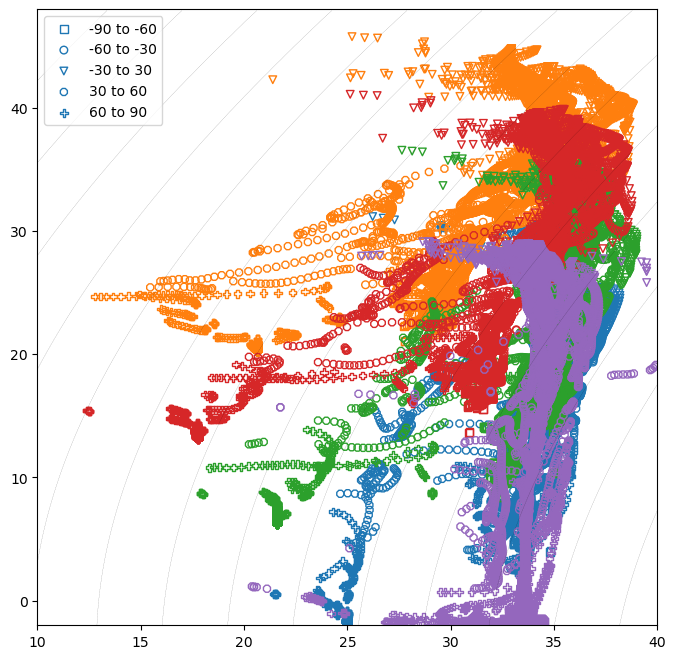

In [999]:
lats = [-90,-60,-30,30,60,90]
colors = [name for name,code in mpl.colors.TABLEAU_COLORS.items()]
markers = ['s','o','v','8','P']
fig,ax = plt.subplots(figsize=(8,8))
for e,experiment in enumerate(dss.experiment):
    dsnow = dss.sel(experiment=experiment)
    for i,lat in enumerate(lats[:-1]):
        cond = (yarray>=lat) & (yarray<lats[i+1])
        latstr = str(lat)+' to '+str(lats[i+1])
        im = ax.scatter(dsnow['so'].where(cond)[::5],dsnow['thetao'].where(cond)[::5],s=30,edgecolors=colors[e],facecolors='none',marker=markers[i],label=latstr)
    if e==0:
        ax.legend(loc='upper left')
ax.contour(sv,tv,sig2array,levels=15,colors='k',linestyles='--',linewidths=0.1)
ax.set_ylim(tlims)
ax.set_xlim(slims)

## Watermass analysis

In [1139]:
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

In [1143]:
latbounds = np.array([[-90,-60],[-30,30],[60,90]])
dsm = {}
dsstd = {}
for i in range(3):
    lats = latbounds[i,:]
    cond = (yarray>=lats[0]) & (yarray<lats[1])
    dsnow = dss.where(cond)
    gridnow = grid.where(cond)
    dsm[i] = dsnow.weighted(gridnow['area'].fillna(0)).mean(['x','y'])
    dsstd[i] = dsnow.weighted(gridnow['area'].fillna(0)).std(['x','y'])

Text(0.5, 1.0, 'Surface ocean T and S (area-weighted mean $\\pm$ std) and $\\sigma_2$ contours')

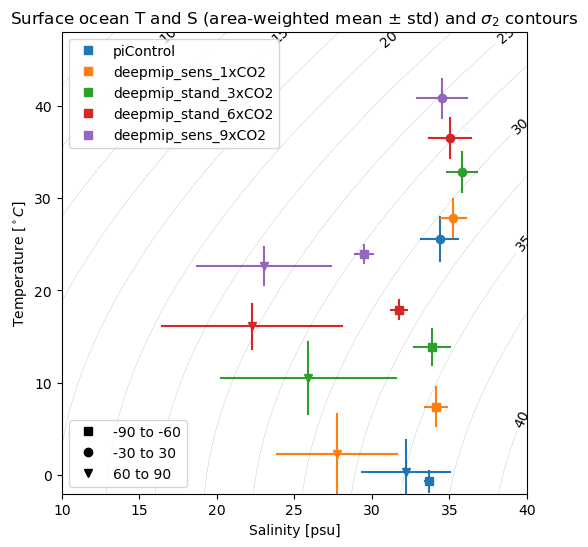

In [1181]:
# end members
fig,ax = plt.subplots(figsize = (6,6))
em_so = [ds['so'] for i,ds in dsm.items()]
em_to = [ds['thetao'] for i,ds in dsm.items()]
em_so_std = [ds['so'] for i,ds in dsstd.items()]
em_to_std = [ds['thetao'] for i,ds in dsstd.items()]
latstr={}
handles_exp = []
for i in range(3):
    lats = latbounds[i,:]
    latstr[i] = str(lats[0])+' to '+str(lats[1])
    for j,experiment in enumerate(experiments):
        s = em_so[i].sel(experiment=experiment)
        t = em_to[i].sel(experiment=experiment)
        ss = em_so_std[i].sel(experiment=experiment)
        ts = em_to_std[i].sel(experiment=experiment)
        h = ax.plot(s,t,linestyle='none',color=colors[j],marker=markers[i],label=experiment)
        if i==0:
            handles_exp.append(h[0])
        ax.plot([s-ss,s+ss],[t,t],linestyle='-',color=colors[j],marker='none')
        ax.plot([s,s],[t-ts,t+ts],linestyle='-',color=colors[j],marker='none')
handles_lat = [mpl.lines.Line2D([], [], color='k', linestyle='none', marker=markers[i], label=latstr[i]) for i in range(3)]
l = ax.legend(handles=handles_exp,loc='upper left')
ax.legend(handles=handles_lat,loc='lower left')
ax.add_artist(l)
cs = ax.contour(sv,tv,sig2array,levels=15,colors='k',linestyles='--',linewidths=0.1)
ax.clabel(cs,cs.levels[::2],inline=True)
ax.set_ylim(tlims)
ax.set_xlim(slims)
ax.set_ylabel(r'Temperature [$^\circ C$]')
ax.set_xlabel(r'Salinity [psu]')
ax.set_title(r'Surface ocean T and S (area-weighted mean $\pm$ std) and $\sigma_2$ contours')

In [1008]:
dsnow = ds.copy()
ones = xr.ones_like(dsnow['so'])
b = np.array([ones,dsnow['so'],dsnow['thetao']])
a = np.array([[ones,ones,ones],
              [ones*ds['so'] for i,ds in dsm.items()],
              [ones*ds['thetao'] for i,ds in dsm.items()]])

In [1010]:
x = np.linalg.solve(np.moveaxis(a, [0, 1], [-2, -1]), np.moveaxis(b, [0], [-1]))

In [1012]:
dse = dsnow['thetao'].expand_dims({'source':['S','Eq','N']},axis=len(dsnow.dims))
fraction = xr.DataArray(x,dims=dse.dims,coords=dse.coords)

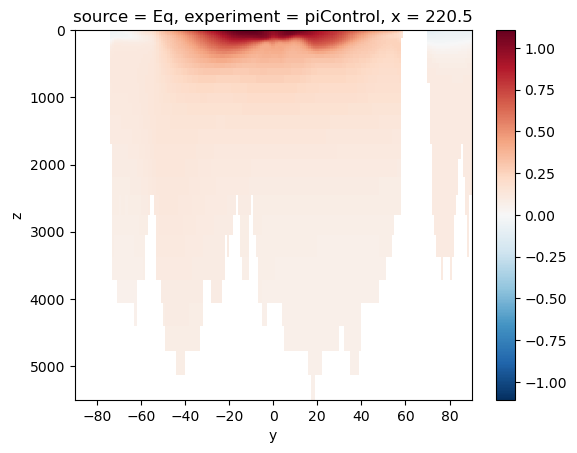

In [1014]:
experiment = 'piControl'
fraction.sel(experiment=experiment,source='Eq').sel(x=220,method='nearest').plot()
plt.gca().invert_yaxis()

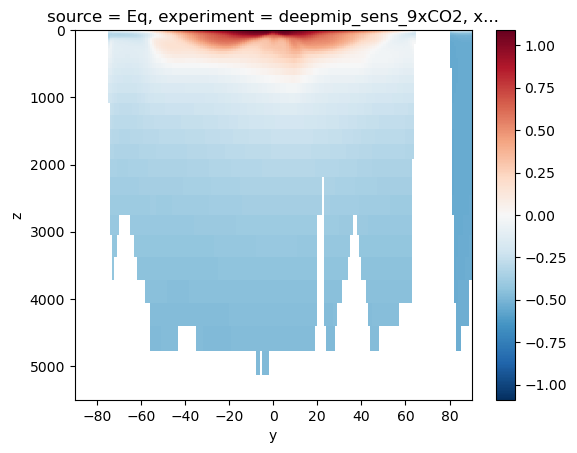

In [1016]:
experiment = 'deepmip_sens_9xCO2'
fraction.sel(experiment=experiment,source='Eq').sel(x=220,method='nearest').plot()
plt.gca().invert_yaxis()

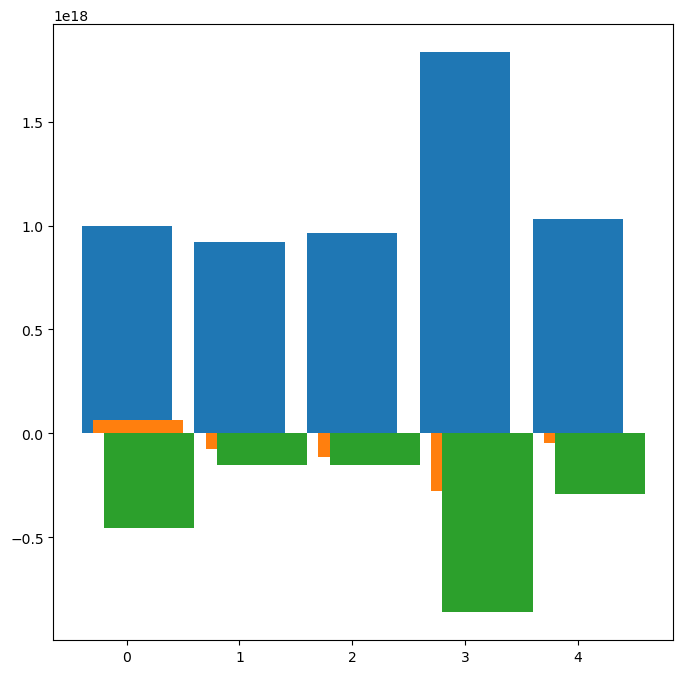

In [691]:
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_sens_9xCO2','deepmip_stand_6xCO2']
fnow = f.sel(z=slice(2000,None))
gridnow = grid.sel(z=slice(2000,None))
fsum = fnow.weighted(gridnow['volume'].fillna(0)).sum(['x','y','z'])
colors = ['tab:blue','tab:orange','tab:green']
fig,ax=plt.subplots(figsize=(8,8))
for i,experiment in enumerate(experiments):
    for j,source in enumerate(fsum.source):
        if j==0:
            bottom=0
        else:
            bottom+=fsumnow
        fsumnow = fsum.sel(experiment=experiment,source=source)
            
        ax.bar(i+j/10,fsumnow,bottom=0,color=colors[j])

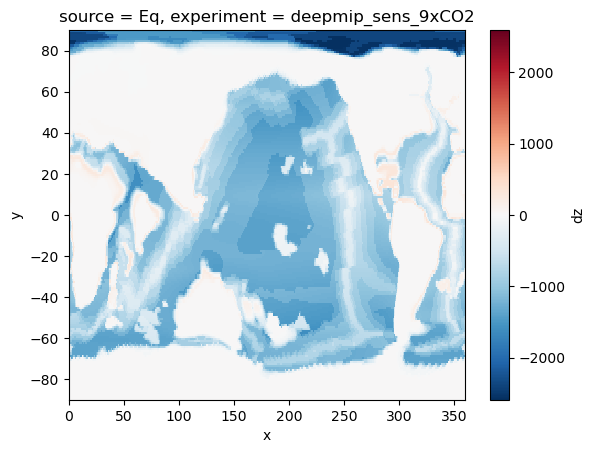

In [695]:
grid['dz'].T.weighted(f.sel(source='Eq').fillna(0)).sum('z').sel(experiment='deepmip_sens_9xCO2').plot()

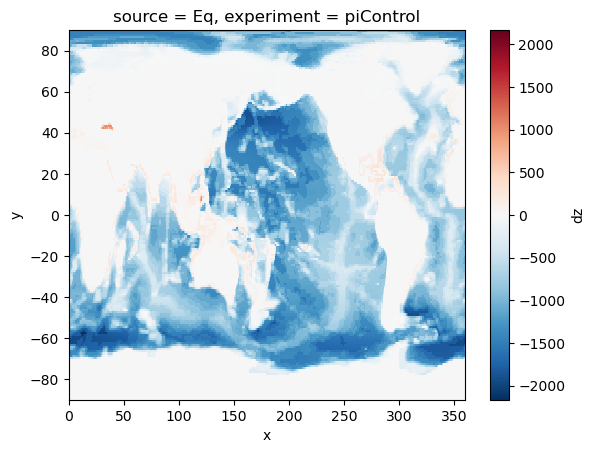

In [641]:
grid['dz'].T.weighted(f.sel(source='Eq').fillna(0)).sum('z').sel(experiment='piControl').plot()

In [697]:
[ds['so'] for i,ds in dsm.items()]

[<xarray.DataArray 'so' (experiment: 5)> Size: 40B
 array([34.13690063, 29.50580698, 33.89149424, 31.74284314, 33.68320618])
 Coordinates:
   * experiment  (experiment) <U19 380B 'deepmip_sens_1xCO2' ... 'piControl'
     z           float64 8B 5.0,
 <xarray.DataArray 'so' (experiment: 5)> Size: 40B
 array([35.25132079, 34.51507963, 35.82487586, 35.06050628, 34.36919649])
 Coordinates:
   * experiment  (experiment) <U19 380B 'deepmip_sens_1xCO2' ... 'piControl'
     z           float64 8B 5.0,
 <xarray.DataArray 'so' (experiment: 5)> Size: 40B
 array([27.72466401, 23.02857779, 25.90945961, 22.25200228, 32.20173053])
 Coordinates:
   * experiment  (experiment) <U19 380B 'deepmip_sens_1xCO2' ... 'piControl'
     z           float64 8B 5.0]